In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Common Data Processing
transform = transforms.Compose([
    transforms.Grayscale(3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
print("Loading datasets...")
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
print("Datasets loaded successfully!")

# Load teacher model
print("Loading teacher model...")
teacher_model = models.resnet50(weights=None)
teacher_model.fc = nn.Linear(2048, 10)
teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_mnist.pth", map_location=device))
teacher_model.to(device)
teacher_model.eval()
print("Teacher model loaded successfully!")

# Function to calculate test accuracy
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    return accuracy

Mounted at /content/drive
Using device: cuda
Loading datasets...


100%|██████████| 9.91M/9.91M [00:00<00:00, 55.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.90MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.93MB/s]


Datasets loaded successfully!
Loading teacher model...
Teacher model loaded successfully!


In [ ]:
# Initialize student model FROM SCRATCH (no pretrained weights)
student_soft = models.resnet18(weights=None)  # Explicitly no pretrained weights
student_soft.fc = nn.Linear(512, 10)  # Adjust final layer for 10-class MNIST
student_soft.to(device)
print("Student model initialized from scratch (no pretrained weights)")

# Distillation loss (unchanged)
class SoftTargetLoss(nn.Module):
    def __init__(self, T=3.0, alpha=0.5):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction="batchmean")
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        soft_loss = self.kl_div(
            F.log_softmax(student_logits/self.T, dim=1),
            F.softmax(teacher_logits/self.T, dim=1)
        ) * (self.T ** 2)
        hard_loss = self.ce_loss(student_logits, labels)
        return self.alpha * hard_loss + (1 - self.alpha) * soft_loss

# Rest of your code remains the same...
optimizer = optim.Adam(student_soft.parameters(), lr=0.001)
criterion = SoftTargetLoss(T=3.0, alpha=0.5)

# Verify teacher model
print("Teacher model verification:")
dummy_input = torch.randn(1, 3, 32, 32).to(device)
try:
    with torch.no_grad():
        teacher_output = teacher_model(dummy_input)
    print("✓ Teacher model works (output shape:", teacher_output.shape, ")")
except Exception as e:
    print("✗ Teacher model failed:", e)
    raise

# Training loop (unchanged)
print("\nStarting Soft Target Distillation Training...")
try:
    for epoch in range(10):
        student_soft.train()
        total_loss = 0.0

        # Test data loading
        print(f"\nEpoch {epoch+1} - Testing data loader...")
        test_images, test_labels = next(iter(train_loader))
        print("✓ Data loader works (batch shape:", test_images.shape, ")")

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                teacher_outputs = teacher_model(images)

            student_outputs = student_soft(images)
            loss = criterion(student_outputs, teacher_outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 50 == 0:
                print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")

        # Calculate metrics
        train_acc = evaluate_model(student_soft, train_loader)
        test_acc = evaluate_model(student_soft, test_loader)

        print(f"Epoch [{epoch+1}/10], Loss: {total_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

except Exception as e:
    print("Training failed:", e)
    raise

# Save final model
torch.save(student_soft.state_dict(), "/content/drive/MyDrive/soft_target_final.pth")
print("✓ Model saved successfully")
print("Soft Target Distillation Complete!")

Student model initialized from scratch (no pretrained weights)
Teacher model verification:
✓ Teacher model works (output shape: torch.Size([1, 10]) )

Starting Soft Target Distillation Training...

Epoch 1 - Testing data loader...
✓ Data loader works (batch shape: torch.Size([64, 3, 28, 28]) )
Batch 0: Loss = 2.0042
Batch 50: Loss = 0.8993
Batch 100: Loss = 0.7630
Batch 150: Loss = 0.7103
Batch 200: Loss = 0.6254
Batch 250: Loss = 0.6481
Batch 300: Loss = 0.6947
Batch 350: Loss = 0.6412
Batch 400: Loss = 0.7024
Batch 450: Loss = 0.7153
Batch 500: Loss = 0.7269
Batch 550: Loss = 0.7038
Batch 600: Loss = 0.6642
Batch 650: Loss = 0.6393
Batch 700: Loss = 0.7129
Batch 750: Loss = 0.6483
Batch 800: Loss = 0.6238
Batch 850: Loss = 0.6580
Batch 900: Loss = 0.6606
Epoch [1/10], Loss: 0.6921, Train Acc: 93.11%, Test Acc: 93.01%

Epoch 2 - Testing data loader...
✓ Data loader works (batch shape: torch.Size([64, 3, 28, 28]) )
Batch 0: Loss = 0.6160
Batch 50: Loss = 0.6264
Batch 100: Loss = 0.6364

In [ ]:
print("\nRunning final evaluation on test set...")
student_soft.eval()  # Set to evaluation mode
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = student_soft(images)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

final_test_acc = 100.0 * total_correct / total_samples
print(f"Final Test Accuracy: {final_test_acc:.2f}%")


Running final evaluation on test set...
Final Test Accuracy: 94.96%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
teacher_model = models.resnet50(weights=None)
teacher_model.fc = nn.Linear(2048, 10)
teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_mnist.pth"))
teacher_model.to(device).eval()

# Student model with attention hooks
class ResNet18AT(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights=None)
        self.model.fc = nn.Linear(512, 10)

        # Register hooks for attention maps
        self.attention_maps = []
        self.handles = []

        # Layers we'll use for attention transfer (typically after residual blocks)
        target_layers = ['layer1', 'layer2', 'layer3']
        for name, layer in self.model.named_modules():
            if name in target_layers:
                self.handles.append(layer.register_forward_hook(self._hook_save_activation))

    def _hook_save_activation(self, module, input, output):
        self.attention_maps.append(output)

    def forward(self, x):
        self.attention_maps = []  # Clear previous maps
        return self.model(x)

    def close(self):
        for handle in self.handles:
            handle.remove()

student_at = ResNet18AT().to(device)

# Attention Transfer Loss
class AttentionTransferLoss(nn.Module):
    def __init__(self, beta=1000):
        super().__init__()
        self.beta = beta
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits,
               student_attention, teacher_attention, labels):
        # Standard cross entropy
        ce_loss = self.ce_loss(student_logits, labels)

        # Attention transfer loss
        at_loss = 0
        for s_att, t_att in zip(student_attention, teacher_attention):
            s_att = self._attention_map(s_att)
            t_att = self._attention_map(t_att)
            at_loss += F.mse_loss(s_att, t_att)

        return ce_loss + self.beta * at_loss

    def _attention_map(self, x):
        return F.normalize(x.pow(2).mean(1).view(x.size(0), -1))

# Training setup
optimizer = optim.Adam(student_at.parameters(), lr=0.001)
criterion = AttentionTransferLoss(beta=1000)

# Data loading (same as before)
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Teacher attention extraction function
def get_teacher_attention(teacher, x):
    attention_maps = []

    def hook_fn(module, input, output):
        attention_maps.append(output)

    handles = []
    target_layers = ['layer1', 'layer2', 'layer3']
    for name, layer in teacher.named_modules():
        if name in target_layers:
            handles.append(layer.register_forward_hook(hook_fn))

    with torch.no_grad():
        _ = teacher(x)

    for handle in handles:
        handle.remove()

    return attention_maps

# Training loop
print("Starting Attention Transfer Distillation...")
for epoch in range(10):
    student_at.train()
    total_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Get teacher attention and outputs
        with torch.no_grad():
            teacher_outputs = teacher_model(images)
            teacher_attention = get_teacher_attention(teacher_model, images)

        # Forward pass through student
        student_outputs = student_at(images)
        student_attention = student_at.attention_maps

        # Compute loss
        loss = criterion(student_outputs, teacher_outputs,
                        student_attention, teacher_attention, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")

    # Evaluation
    student_at.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student_at(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/10], Loss: {total_loss/len(train_loader):.4f}, "
          f"Test Acc: {test_acc:.2f}%")

# Final evaluation
student_at.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = student_at(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_acc = 100 * correct / total
print(f"\nFinal Test Accuracy: {final_acc:.2f}%")

# Save model
torch.save(student_at.model.state_dict(), "/content/drive/MyDrive/attention_transfer_final.pth")
print("✓ Model saved successfully")
student_at.close()  # Remove hooks

Starting Attention Transfer Distillation...
Batch 0: Loss = 81.3155
Batch 50: Loss = 2.9661
Batch 100: Loss = 2.4291
Batch 150: Loss = 1.5411
Batch 200: Loss = 1.8795
Batch 250: Loss = 1.3226
Batch 300: Loss = 1.0884
Batch 350: Loss = 1.4972
Batch 400: Loss = 2.6888
Batch 450: Loss = 1.2004
Batch 500: Loss = 0.8917
Batch 550: Loss = 0.8630
Batch 600: Loss = 0.8361
Batch 650: Loss = 0.7674
Batch 700: Loss = 0.9480
Batch 750: Loss = 0.8772
Batch 800: Loss = 0.7945
Batch 850: Loss = 0.6903
Batch 900: Loss = 0.7994
Epoch [1/10], Loss: 1.6736, Test Acc: 93.72%
Batch 0: Loss = 0.6153
Batch 50: Loss = 0.6735
Batch 100: Loss = 0.7624
Batch 150: Loss = 0.9390
Batch 200: Loss = 0.6888
Batch 250: Loss = 0.6382
Batch 300: Loss = 0.5123
Batch 350: Loss = 0.3936
Batch 400: Loss = 0.6259
Batch 450: Loss = 0.6275
Batch 500: Loss = 0.7583
Batch 550: Loss = 0.6020
Batch 600: Loss = 1.0465
Batch 650: Loss = 0.4374
Batch 700: Loss = 0.5133
Batch 750: Loss = 0.6482
Batch 800: Loss = 0.3375
Batch 850: Loss 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simplified ResNet18 definition matching your saved models
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        # Use the standard resnet18 structure without wrapper
        self.resnet = models.resnet18(weights=None)
        self.resnet.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.resnet(x)

# Initialize two ResNet-18 students
student1 = ResNet18().to(device)
student2 = ResNet18().to(device)

# Load paths (update these with your actual paths)
student1_path = "/content/drive/MyDrive/soft_target_final.pth"
student2_path = "/content/drive/MyDrive/attention_transfer_final.pth"

# Modified loading function to handle potential architecture mismatches
def load_model(model, path):
    try:
        # Load full state dict
        state_dict = torch.load(path, map_location=device)

        # Handle case where model was saved as DataParallel
        if all(k.startswith('module.') for k in state_dict.keys()):
            state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

        # Handle case where model was saved with 'resnet.' prefix
        if all(k.startswith('resnet.') for k in state_dict.keys()):
            state_dict = {k.replace('resnet.', ''): v for k, v in state_dict.items()}

        model.load_state_dict(state_dict, strict=False)  # strict=False to ignore non-matching keys
        print(f"✓ Model loaded successfully from {path}")
        return True
    except Exception as e:
        print(f"✗ Error loading model from {path}: {e}")
        return False

# Load models
if not load_model(student1, student1_path):
    raise RuntimeError("Failed to load student1")
if not load_model(student2, student2_path):
    raise RuntimeError("Failed to load student2")

# DML Loss (bidirectional KL divergence)
class DMLLoss(nn.Module):
    def __init__(self, T=3.0, alpha=0.5):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, logits1, logits2, labels):
        # Classification loss
        ce_loss = (self.ce_loss(logits1, labels) + self.ce_loss(logits2, labels)) / 2

        # Mutual learning loss
        soft_loss = (self.kl_div(
            F.log_softmax(logits1/self.T, dim=1),
            F.softmax(logits2/self.T, dim=1)
        ) + self.kl_div(
            F.log_softmax(logits2/self.T, dim=1),
            F.softmax(logits1/self.T, dim=1)
        )) * (self.T ** 2) / 2

        return self.alpha * ce_loss + (1 - self.alpha) * soft_loss

# Training setup
optimizer1 = optim.Adam(student1.parameters(), lr=0.0005)
optimizer2 = optim.Adam(student2.parameters(), lr=0.0005)
criterion = DMLLoss(T=3.0, alpha=0.5)

# Data loading
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# DML Training loop
print("Starting Deep Mutual Learning between ResNet-18 students...")
for epoch in range(5):
    student1.train()
    student2.train()
    total_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward passes
        outputs1 = student1(images)
        outputs2 = student2(images)

        # Compute DML loss
        loss = criterion(outputs1, outputs2, labels)

        # Backward passes
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer1.step()
        optimizer2.step()

        total_loss += loss.item()

        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")

    # Evaluation
    student1_acc = evaluate_model(student1, test_loader)
    student2_acc = evaluate_model(student2, test_loader)

    print(f"Epoch [{epoch+1}/5], Loss: {total_loss/len(train_loader):.4f}, "
          f"Student1 Acc: {student1_acc:.2f}%, Student2 Acc: {student2_acc:.2f}%")

# Final evaluation
final_acc1 = evaluate_model(student1, test_loader)
final_acc2 = evaluate_model(student2, test_loader)
print(f"\nFinal Test Accuracy - Student1: {final_acc1:.2f}%, Student2: {final_acc2:.2f}%")

# Save models
torch.save(student1.state_dict(), "/content/drive/MyDrive/dml_resnet18_student1_final.pth")
torch.save(student2.state_dict(), "/content/drive/MyDrive/dml_resnet18_student2_final.pth")
print("✓ Both models saved successfully")

✓ Model loaded successfully from /content/drive/MyDrive/soft_target_final.pth
✓ Model loaded successfully from /content/drive/MyDrive/attention_transfer_final.pth
Starting Deep Mutual Learning between ResNet-18 students...
Batch 0: Loss = 1.6044
Batch 50: Loss = 0.2014
Batch 100: Loss = 0.1167
Batch 150: Loss = 0.0615
Batch 200: Loss = 0.1172
Batch 250: Loss = 0.0976
Batch 300: Loss = 0.2322
Batch 350: Loss = 0.0875
Batch 400: Loss = 0.1117
Batch 450: Loss = 0.0848
Batch 500: Loss = 0.0598
Batch 550: Loss = 0.0575
Batch 600: Loss = 0.0629
Batch 650: Loss = 0.0443
Batch 700: Loss = 0.1337
Batch 750: Loss = 0.1150
Batch 800: Loss = 0.0792
Batch 850: Loss = 0.0950
Batch 900: Loss = 0.0982
Epoch [1/5], Loss: 0.1147, Student1 Acc: 98.33%, Student2 Acc: 98.04%
Batch 0: Loss = 0.1003
Batch 50: Loss = 0.0242
Batch 100: Loss = 0.0426
Batch 150: Loss = 0.0541
Batch 200: Loss = 0.0467
Batch 250: Loss = 0.0488
Batch 300: Loss = 0.0937
Batch 350: Loss = 0.0251
Batch 400: Loss = 0.0654
Batch 450: Lo

In [ ]:
import torch
import time
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Teacher Model (ResNet-50)
teacher_model = models.resnet50(weights=None)
teacher_model.fc = torch.nn.Linear(2048, 10)  # Adjust output layer for MNIST
teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_mnist.pth", map_location=device))
teacher_model.to(device).eval()

# Load Student Models (ResNet-18) AFTER DML
student_model1 = models.resnet18(weights=None)
student_model1.fc = torch.nn.Linear(512, 10)  # Adjust output layer for MNIST
student_model1.load_state_dict(torch.load("/content/drive/MyDrive/dml_resnet18_student1_final.pth", map_location=device), strict=False)
student_model1.to(device).eval()

student_model2 = models.resnet18(weights=None)
student_model2.fc = torch.nn.Linear(512, 10)  # Adjust output layer for MNIST
student_model2.load_state_dict(torch.load("/content/drive/MyDrive/dml_resnet18_student2_final.pth", map_location=device), strict=False)
student_model2.to(device).eval()

# Load Student Models BEFORE DML (Soft Target and Attention Transfer)
student_model1_before_dml = models.resnet18(weights=None)
student_model1_before_dml.fc = torch.nn.Linear(512, 10)
student_model1_before_dml.load_state_dict(torch.load("/content/drive/MyDrive/soft_target_final.pth", map_location=device), strict=False)
student_model1_before_dml.to(device).eval()

student_model2_before_dml = models.resnet18(weights=None)
student_model2_before_dml.fc = torch.nn.Linear(512, 10)
student_model2_before_dml.load_state_dict(torch.load("/content/drive/MyDrive/attention_transfer_final.pth", map_location=device), strict=False)
student_model2_before_dml.to(device).eval()

# Data transformation (MNIST to ResNet format)
transform = transforms.Compose([
    transforms.Grayscale(3),  # Convert grayscale to 3 channels
    transforms.Resize(224),   # Resize for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load MNIST dataset correctly
mnist_test = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# Get a single test image
test_image, _ = next(iter(test_loader))
test_image = test_image.to(device)  # Move to GPU if available

# Function to measure inference time
def measure_inference_time(model, input_tensor, num_runs=100):
    model.eval()

    # Warm-up runs
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_tensor)

    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_tensor)

    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs
    return avg_time * 1000  # Convert to milliseconds

# Measure inference time for Teacher and Student Models (After DML)
teacher_time = measure_inference_time(teacher_model, test_image)
student_time1 = measure_inference_time(student_model1, test_image)
student_time2 = measure_inference_time(student_model2, test_image)

# Measure inference time for Student Models (Before DML)
student_time1_before_dml = measure_inference_time(student_model1_before_dml, test_image)
student_time2_before_dml = measure_inference_time(student_model2_before_dml, test_image)

# Print Inference Times and Speedup Factors
print(f"Teacher Model (ResNet-50) Inference Time: {teacher_time:.3f} ms")
print(f"Student Model 1 (ResNet-18) Inference Time (AFTER DML): {student_time1:.3f} ms")
print(f"Student Model 2 (ResNet-18) Inference Time (AFTER DML): {student_time2:.3f} ms")
print(f"Student Model 1 Inference Time (BEFORE DML - Soft Target): {student_time1_before_dml:.3f} ms")
print(f"Student Model 2 Inference Time (BEFORE DML - Attention Transfer): {student_time2_before_dml:.3f} ms")

print(f"Speedup Factor (Teacher vs Student 1 AFTER DML): {teacher_time / student_time1:.2f}x Faster")
print(f"Speedup Factor (Teacher vs Student 2 AFTER DML): {teacher_time / student_time2:.2f}x Faster")
print(f"Speedup Factor (Teacher vs Student 1 BEFORE DML): {teacher_time / student_time1_before_dml:.2f}x Faster")
print(f"Speedup Factor (Teacher vs Student 2 BEFORE DML): {teacher_time / student_time2_before_dml:.2f}x Faster")


Teacher Model (ResNet-50) Inference Time: 179.500 ms
Student Model 1 (ResNet-18) Inference Time (AFTER DML): 80.619 ms
Student Model 2 (ResNet-18) Inference Time (AFTER DML): 77.167 ms
Student Model 1 Inference Time (BEFORE DML - Soft Target): 88.632 ms
Student Model 2 Inference Time (BEFORE DML - Attention Transfer): 81.915 ms
Speedup Factor (Teacher vs Student 1 AFTER DML): 2.23x Faster
Speedup Factor (Teacher vs Student 2 AFTER DML): 2.33x Faster
Speedup Factor (Teacher vs Student 1 BEFORE DML): 2.03x Faster
Speedup Factor (Teacher vs Student 2 BEFORE DML): 2.19x Faster


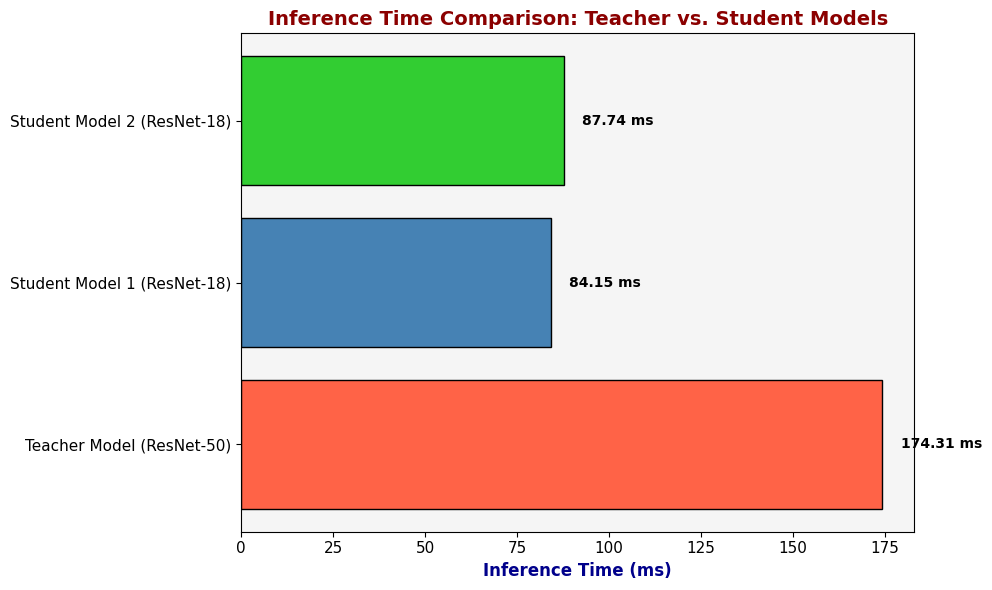

In [ ]:
import matplotlib.pyplot as plt

# Create a horizontal bar chart with unique styling
models = ['Teacher Model (ResNet-50)', 'Student Model 1 (ResNet-18)', 'Student Model 2 (ResNet-18)']
times = [teacher_time, student_time1, student_time2]

# Plotting the inference times
plt.figure(figsize=(10, 6))

# Create horizontal bars with custom color, edge color, and width
bars = plt.barh(models, times, color=['#FF6347', '#4682B4', '#32CD32'], edgecolor='black', height=0.8)

# Add annotations on top of each bar (inference time in ms)
for bar in bars:
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f} ms',
             va='center', fontweight='bold', color='black')

# Set background color to a subtle light color (avoiding the harsh grid lines)
plt.gca().set_facecolor('whitesmoke')

# Add labels and title with custom styling
plt.xlabel('Inference Time (ms)', fontsize=12, fontweight='bold', color='darkblue')
plt.title('Inference Time Comparison: Teacher vs. Student Models', fontsize=14, fontweight='bold', color='darkred')

# Remove grid lines and customize the ticks
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Show the plot with a cleaner layout
plt.tight_layout()
plt.show()


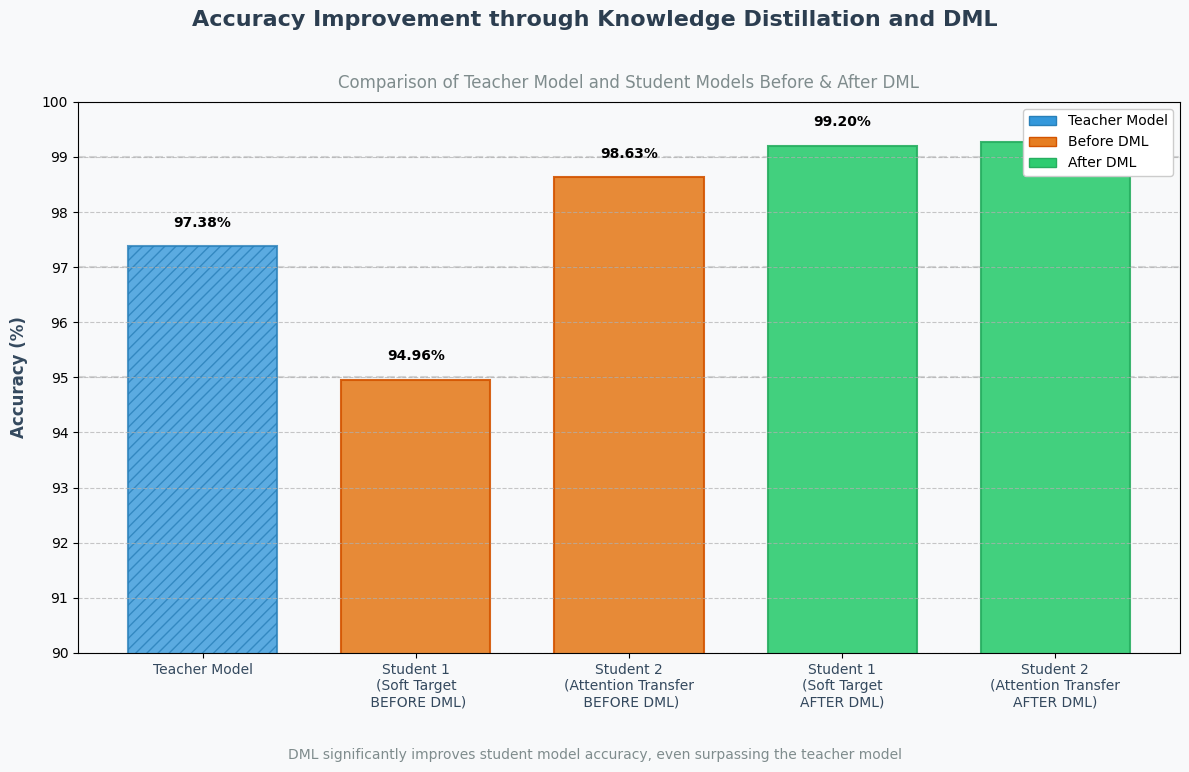

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# Data
models = ['Teacher Model', 'Student 1\n(Soft Target\n BEFORE DML)', 'Student 2\n(Attention Transfer\n BEFORE DML)',
          'Student 1\n(Soft Target\nAFTER DML)', 'Student 2\n(Attention Transfer\nAFTER DML)']
accuracies = [97.38, 94.96, 98.63, 99.20, 99.28]

# Create figure with light gray background
plt.figure(figsize=(12, 7), facecolor='#f8f9fa')
ax = plt.gcf().add_subplot(facecolor='#f8f9fa')

# Custom colors
colors = ['#3498db', '#e67e22', '#e67e22', '#2ecc71', '#2ecc71']
edge_colors = ['#2980b9', '#d35400', '#d35400', '#27ae60', '#27ae60']

# Plotting the data with bars
bars = ax.bar(models, accuracies, color=colors, edgecolor=edge_colors,
              linewidth=1.5, alpha=0.9, width=0.7)

# Customize bars - make teacher model stand out
bars[0].set_hatch('///')
bars[0].set_alpha(0.8)

# Add value labels on top of each bar
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Customize y-axis
ax.set_ylim(90, 100)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold', color='#34495e', labelpad=10)

# Title and subtitle
plt.suptitle('Accuracy Improvement through Knowledge Distillation and DML',
             fontsize=16, fontweight='bold', color='#2c3e50', y=1.02)
plt.title('Comparison of Teacher Model and Student Models Before & After DML',
          fontsize=12, color='#7f8c8d', pad=10)

# Customize x-axis labels
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, fontsize=10, color='#34495e')

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', edgecolor='#2980b9', label='Teacher Model'),
    Patch(facecolor='#e67e22', edgecolor='#d35400', label='Before DML'),
    Patch(facecolor='#2ecc71', edgecolor='#27ae60', label='After DML')
]
ax.legend(handles=legend_elements, loc='upper right', framealpha=1)

# Add horizontal lines for reference
for y in [95, 97, 99]:
    ax.axhline(y, color='gray', linestyle='--', alpha=0.3, zorder=0)

# Add footer text
plt.figtext(0.5, -0.05, "DML significantly improves student model accuracy, even surpassing the teacher model",
            ha="center", fontsize=10, color='#7f8c8d')

# Adjust layout
plt.tight_layout()

plt.show()

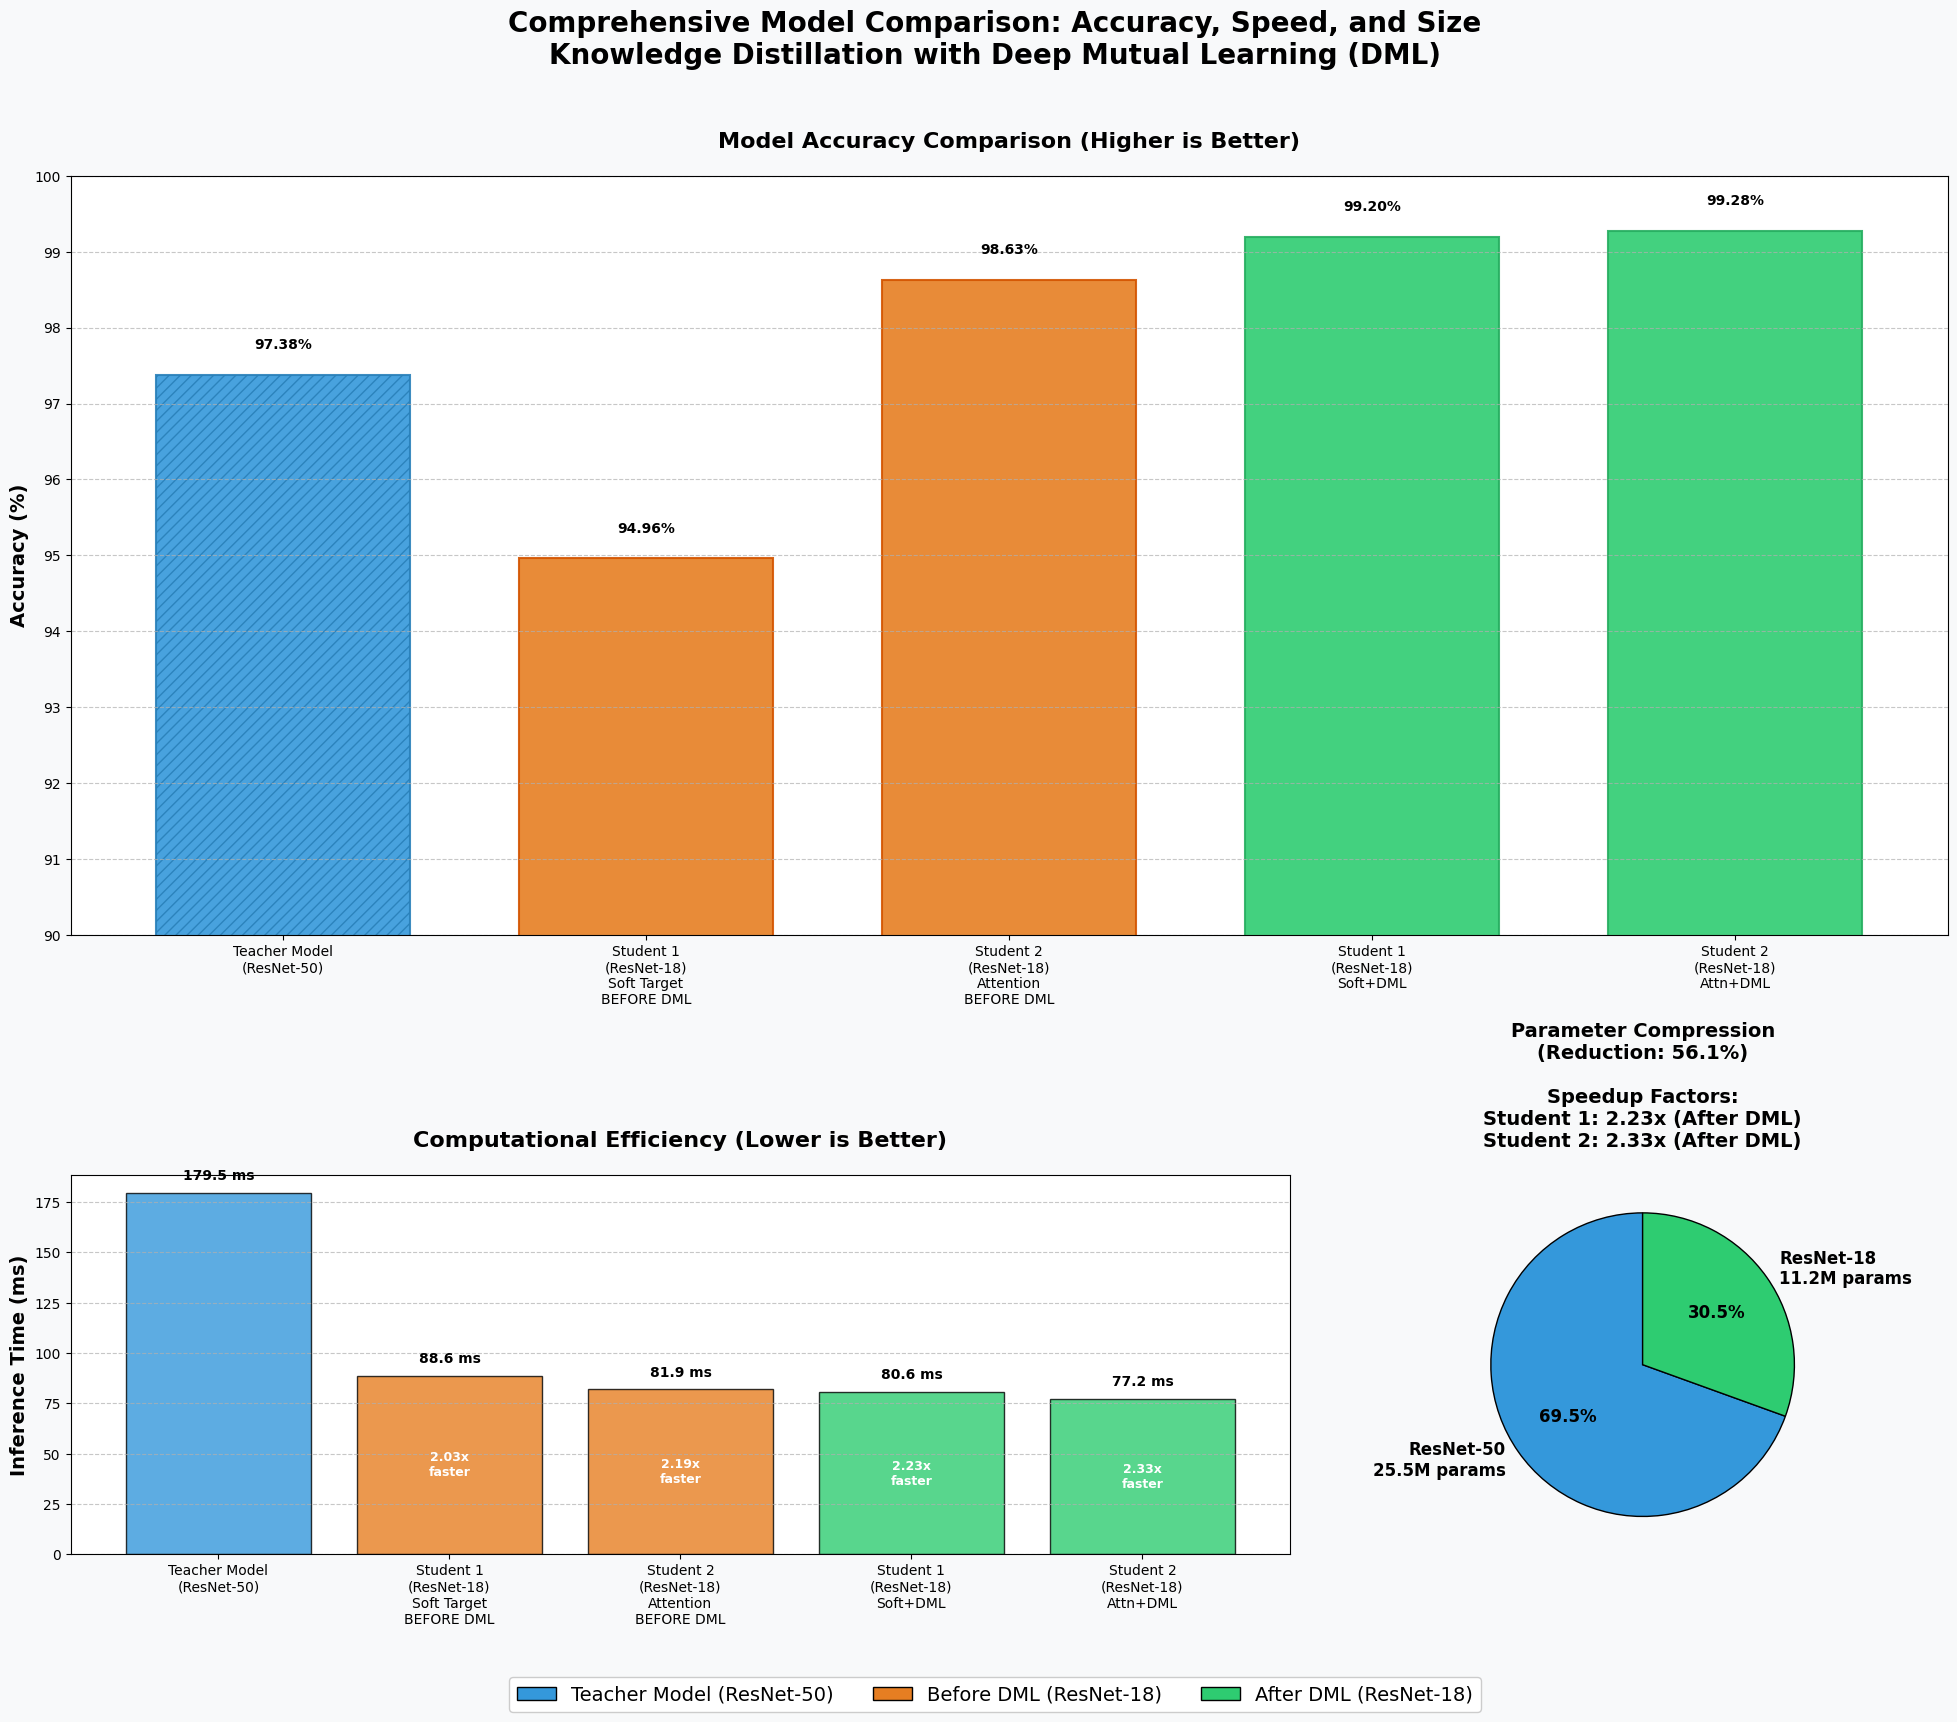

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

# Data
models = ['Teacher Model\n(ResNet-50)',
          'Student 1\n(ResNet-18)\nSoft Target\nBEFORE DML',
          'Student 2\n(ResNet-18)\nAttention\nBEFORE DML',
          'Student 1\n(ResNet-18)\nSoft+DML',
          'Student 2\n(ResNet-18)\nAttn+DML']
accuracies = [97.38, 94.96, 98.63, 99.20, 99.28]
inference_times = [179.500, 88.632, 81.915, 80.619, 77.167]  # Your exact times in ms
speedup_factors = ['-', '2.03x', '2.19x', '2.23x', '2.33x']
teacher_params = 25.5e6  # ResNet-50 parameters
student_params = 11.2e6  # ResNet-18 parameters

# Create figure
plt.figure(figsize=(20, 16), facecolor='#f8f9fa')
gs = GridSpec(2, 2, figure=plt.gcf(), height_ratios=[2, 1], width_ratios=[2, 1])

# ========== Accuracy Plot ==========
ax1 = plt.subplot(gs[0, :])
colors = ['#3498db', '#e67e22', '#e67e22', '#2ecc71', '#2ecc71']
edge_colors = ['#2980b9', '#d35400', '#d35400', '#27ae60', '#27ae60']

bars = ax1.bar(models, accuracies, color=colors, edgecolor=edge_colors,
               linewidth=1.5, alpha=0.9, width=0.7)

# Customize bars
bars[0].set_hatch('///')
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting
ax1.set_ylim(90, 100)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Model Accuracy Comparison (Higher is Better)', fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# ========== Inference Time Plot ==========
ax2 = plt.subplot(gs[1, 0])
time_colors = ['#3498db', '#e67e22', '#e67e22', '#2ecc71', '#2ecc71']
time_bars = ax2.bar(models, inference_times, color=time_colors, edgecolor='black', alpha=0.8)

# Add time labels and speedup factors
for bar, time, speedup in zip(time_bars, inference_times, speedup_factors):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
             f'{time:.1f} ms', ha='center', va='bottom', fontweight='bold', fontsize=10)
    if speedup != '-':
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
                 f'{speedup}\nfaster', ha='center', va='center',
                 fontweight='bold', color='white', fontsize=9)

ax2.set_ylabel('Inference Time (ms)', fontsize=14, fontweight='bold')
ax2.set_title('Computational Efficiency (Lower is Better)', fontsize=16, fontweight='bold', pad=20)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# ========== Compression Ratio Plot ==========
ax3 = plt.subplot(gs[1, 1])
compression_ratio = student_params / teacher_params
reduction = (1 - compression_ratio) * 100

sizes = [teacher_params/1e6, student_params/1e6]
labels = [f'ResNet-50\n{teacher_params/1e6:.1f}M params',
          f'ResNet-18\n{student_params/1e6:.1f}M params']
colors = ['#3498db', '#2ecc71']

wedges, texts, autotexts = ax3.pie(sizes, labels=labels, colors=colors,
                                  autopct='%1.1f%%', startangle=90,
                                  textprops={'fontweight': 'bold', 'fontsize': 12},
                                  wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax3.set_title(f'Parameter Compression\n(Reduction: {reduction:.1f}%)\n\nSpeedup Factors:\n'
              f'Student 1: 2.23x (After DML)\n'
              f'Student 2: 2.33x (After DML)',
              fontsize=14, fontweight='bold', pad=20)

# ========== Common Formatting ==========
# Add legend
legend_elements = [
    Patch(facecolor='#3498db', edgecolor='black', label='Teacher Model (ResNet-50)'),
    Patch(facecolor='#e67e22', edgecolor='black', label='Before DML (ResNet-18)'),
    Patch(facecolor='#2ecc71', edgecolor='black', label='After DML (ResNet-18)')
]
plt.figlegend(handles=legend_elements, loc='lower center', ncol=3,
              fontsize=14, framealpha=1, bbox_to_anchor=(0.5, -0.05))

# Main title
plt.suptitle('Comprehensive Model Comparison: Accuracy, Speed, and Size\n'
             'Knowledge Distillation with Deep Mutual Learning (DML)',
             fontsize=20, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()